In [1]:
import numpy as np
import pandas as pd
import toolz as tz
import itertools as it
import functools as ft

import seaborn as sns

import rospy
from rosh import Bagy

from robot_wardrive.msg import SignalLocation, PingLocation

# Load Data

In [2]:
ls patrolling_2015-06-08/

2015-06-08-10-52_google.bagy  2015-06-08-10-52_signal_location.bagy
2015-06-08-10-52_google.csv   2015-06-08-15-42_google.bagy
2015-06-08-10-52_mpc.bagy     2015-06-08-15-42_mpc.bagy
2015-06-08-10-52_mpc.csv


In [3]:
def read_bagy(msg_type, bagy_name):
    """Read a single bagy and return it as a pandas.DataFrame."""
    msgs = None
    with Bagy(bagy_name, 'r', PingLocation) as bagy:
        msgs = pd.DataFrame([(msg.header.stamp.secs, msg.pose.position.x, msg.pose.position.y, msg.delay) for msg in bagy], columns=columns)
    return msgs

def read_bagys(msg_type, *bagys):
    """Read several bagys and return them as a pandas.DataFrame."""
    dataframes = (read_bagy(msg_type, bagy) for bagy in bagys)
    return pd.concat(list(dataframes))
    
    


In [4]:
columns=['secs', 'x', 'y', 'delay']

bagy_names = ['patrolling_2015-06-08/2015-06-08-10-52_google.bagy',
              'patrolling_2015-06-12/2015-06-12-12-11_google.bagy']

msgs = read_bagys(PingLocation, *bagy_names)
msgs = msgs[msgs.x != 0.0]   # Remove values where x==0

In [5]:
# msgs.to_csv('2015-06-08-10-52_google.csv')

In [6]:
msgs.head()

,secs,x,y,delay
1,1433753552,15.49182,32.360715,2.71
2,1433753552,15.49182,32.360715,3.25
3,1433753553,15.49182,32.360715,2.76
4,1433753553,15.49182,32.360715,2.74
5,1433753554,15.49182,32.360715,3.07


In [7]:
msgs.describe()

,secs,x,y,delay
count,1.928700e+04,19287.000000,19287.000000,19287.000000
mean,1.433897e+09,13.154439,43.989605,8.525823
std,1.712069e+05,1.634647,24.974299,71.478673
min,1.433754e+09,7.062708,3.973411,2.570000
25%,1.433756e+09,11.983480,32.798076,2.720000
50%,1.433759e+09,13.840187,33.668992,2.780000
75%,1.434106e+09,13.979883,56.363860,3.140000
max,1.434109e+09,19.220119,109.012535,2968.000000


#Rounding 

In [31]:
rounded = msgs.apply(np.round, decimals=0)

In [32]:
rounded.describe()

,secs,x,y,delay
count,1.928700e+04,19287.000000,19287.000000,19287.000000
mean,1.433897e+09,13.188936,44.129310,8.687354
std,1.712069e+05,1.630390,24.916812,71.465772
min,1.433754e+09,7.000000,4.000000,3.000000
25%,1.433756e+09,12.000000,33.000000,3.000000
50%,1.433759e+09,14.000000,34.000000,3.000000
75%,1.434106e+09,14.000000,56.000000,3.000000
max,1.434109e+09,19.000000,109.000000,2968.000000


In [33]:
rounded = rounded.groupby(['x', 'y']).mean().reset_index(inplace=False)

In [34]:
rounded.head()

,x,y,secs,delay
0,7,15,1433754340,70.575000
1,7,16,1433754369,41.750000
2,8,15,1433754421,38.780488
3,8,16,1434097372,44.964401
4,8,17,1433754362,54.545455


In [35]:
rounded.describe()

,x,y,secs,delay
count,303.000000,303.000000,3.030000e+02,303.000000
mean,12.907591,41.587459,1.433970e+09,12.698908
std,2.151091,27.748721,1.178543e+05,32.870101
min,7.000000,4.000000,1.433754e+09,3.000000
25%,12.000000,16.500000,1.433930e+09,3.288690
50%,12.000000,33.000000,1.433979e+09,3.681818
75%,14.000000,62.000000,1.434106e+09,5.776386
max,19.000000,109.000000,1.434108e+09,256.500000


### Seting Max delay to 1000ms

In [36]:
#rounded.delay = rounded.delay.apply(lambda x: 1500 if x > 1500 else x)

# Plots

## Plot Hexbin 

In [13]:
%pylab qt

# Set image limits
extent=[min(rounded.x - 6.55), max(rounded.x + 5.55),
       min(rounded.y - 4.6),max(rounded.y + 11.4)]

plt.hexbin(msgs.x, msgs.y, msgs.delay, gridsize=150,
           reduce_C_function=np.median, bins='log',
           cmap='winter_r', alpha=0.4, linewidths=0.01, label='log(ping)')
plt.colorbar()
img = plt.imread('roboticslab_complete_clean.png')
implot = plt.imshow(img, extent=extent, cmap='Greys_r')
axes().set_aspect('equal', 'datalim')
plt.grid(b=None)
plt.savefig('ping_locations_hexbin.pdf', grid=None, transparent=False, dpi=300)

Populating the interactive namespace from numpy and matplotlib


## Plot rounded scatter

In [37]:
# Set image limits
extent=[min(rounded.x - 6.55), max(rounded.x + 5.55),
       min(rounded.y - 4.6),max(rounded.y + 11.4)]

In [38]:
%pylab inline
pylab.rcParams['figure.figsize'] = (8.0, 22.0)

Populating the interactive namespace from numpy and matplotlib


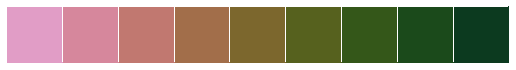

In [46]:
# Choose Palete from cubehelix
# Retrieved from: http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html
cmap = sns.choose_cubehelix_palette(as_cmap=True)

In [49]:
#cmap = sns.cubehelix_palette(n_colors=10, start=1, rot=-0.7,
#                             gamma=1.3, hue=0.8, light=0.6, dark=0.3,
#                             reverse=False, as_cmap=True)

cmap = sns.cubehelix_palette(n_colors=9, start=0, rot=-1,
                             gamma=1.4, hue=0.7, light=0.7, dark=0.3,
                             reverse=False, as_cmap=True)

cmap = sns.cubehelix_palette(n_colors=4, start=0, rot=0.9,
                             gamma=1.5, hue=1, light=0.8, dark=0.3,
                             reverse=False, as_cmap=True)

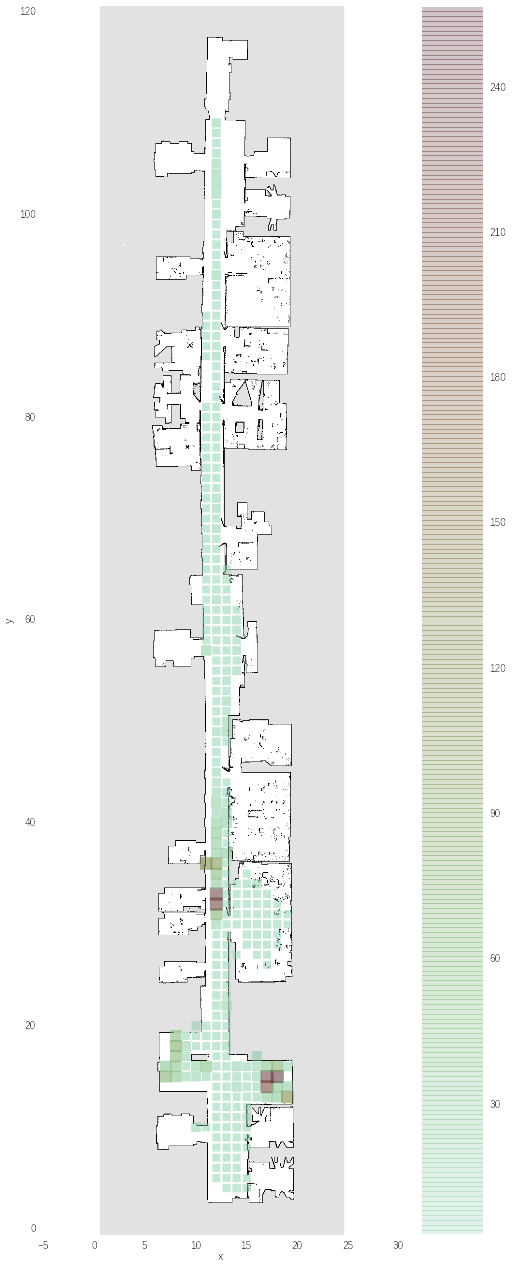

In [54]:
rounded.plot(kind='scatter', x='x', y='y', c='delay', marker='s',
             # s=rounded.delay/2, linewidth=0, alpha=0.5,
             s=25*np.log(rounded.delay*4), linewidth=0, alpha=0.5,
             grid=None, cmap=cmap)  # cmap=*_r is reversed version of the cmap
             # grid=None, cmap="autumn_r")  # cmap=*_r is reversed version of the cmap
             #grid=None, cmap="winter")  # cmap=*_r is reversed version of the cmap
img = plt.imread('roboticslab_complete_clean.png')
implot = plt.imshow(img, extent=extent, cmap='Greys_r')
axes().set_aspect('equal', 'datalim')
plt.xlim(0,25)
plt.grid(b=None)
plt.savefig('ping_locations.pdf', grid=None, transparent=False, dpi=300)

# Timestamp vs delay


In [48]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


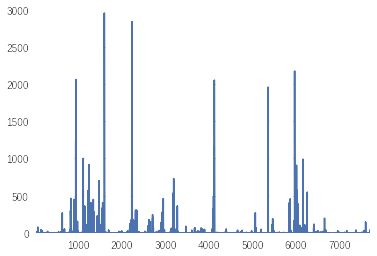

In [49]:
msgs.delay.plot()

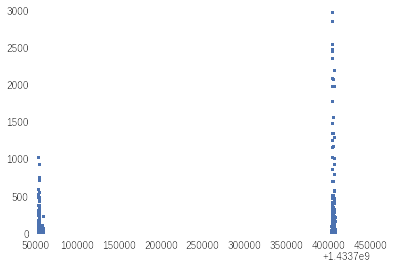

In [50]:
plt.plot(msgs.secs, msgs.delay, '.')

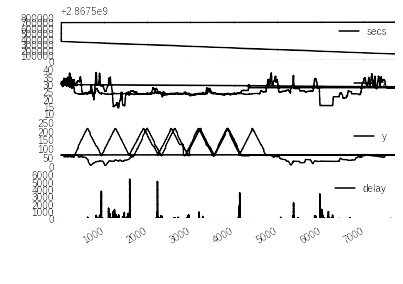

In [51]:
pd.rolling_sum(msgs, 2).plot(subplots=True)
plt.savefig('test.pdf', ls=0.1)

In [52]:
msgs_patrolling = msgs[0:5500]
msgs_docked = msgs[6000:]

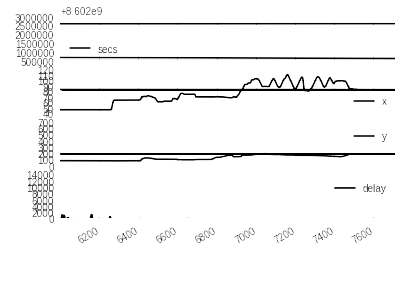

In [53]:
pd.rolling_sum(msgs_docked, 6).plot(subplots=True)
plt.savefig('test_docked.pdf', ls=0.1)

array([<matplotlib.axes.AxesSubplot object at 0xf63826c>,
       <matplotlib.axes.AxesSubplot object at 0xe56546c>], dtype=object)

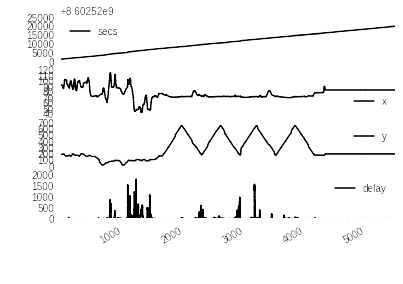

In [54]:
pd.rolling_sum(msgs_patrolling, 6).plot(subplots=True)
# plt.savefig('test_patrolling.pdf', ls=0.1)

# Plot Docked

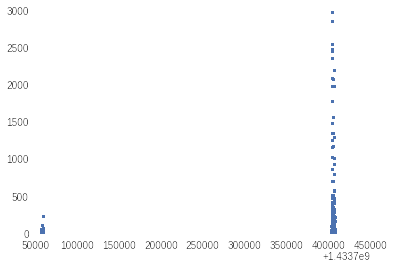

In [55]:
plt.plot(msgs_docked.secs, msgs_docked.delay, '.')

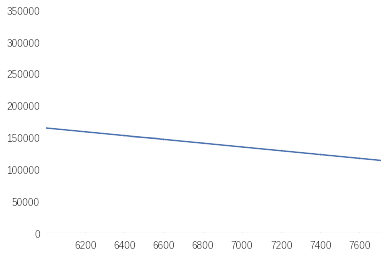

In [56]:
import operator as op
pd.rolling_apply(msgs_docked.secs, 2, np.diff).plot()

# Plot Patrolling

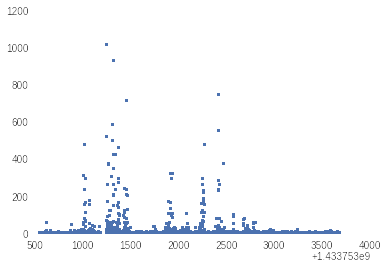

In [57]:
plt.plot(msgs_patrolling.secs, msgs_patrolling.delay, '.')

### Plot Network Losses

Populating the interactive namespace from numpy and matplotlib


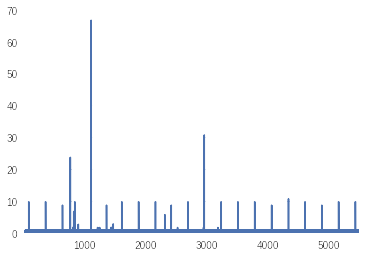

In [58]:
%pylab inline
import operator as op
pd.rolling_apply(msgs_patrolling.secs, 2, np.diff).plot()

# Measuring time between Network Losses

Getting delay between messages when the robot was docked

In [59]:
delays = msgs_docked.secs - msgs_docked.secs.shift()
delays.head()

6001   NaN
6002     1
6003     0
6004     1
6005     0
Name: secs, dtype: float64

As you can see, mean delay is a bit higer than 0.5, which is the rate at which pings were sent

In [60]:
delays.describe()

count     13286.000000
mean         26.466657
std        2985.977840
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max      344179.000000
Name: secs, dtype: float64

Now we are going to discard normal messages and get only messages received after network losses so we can get the delay between them:

In [61]:
network_losses = pd.Series(delays[delays>1].index)
network_losses.head()

0    6259
1    6535
2    6812
3    7089
4    7367
dtype: int64

In [62]:
network_losses.count()

77

As we can see, we've got 20 network losses in our dataset. Now let's measure how much time passed between them

In [63]:
time_between_losses = pd.rolling_apply(pd.Series(delays[delays>1].index/2), 2, np.diff)
time_between_losses

0     NaN
1     138
2     139
3     138
4     139
5     138
6     138
7     139
8     138
9     139
10    139
11    138
12    137
13    138
14    138
...
62      8
63      5
64      1
65      7
66      7
67      8
68      7
69      7
70      4
71    123
72    138
73    138
74    138
75     60
76     78
Length: 77, dtype: float64

We can see that network losses have been fairly periodical with a mean period of almost **140 seconds**:

In [64]:
time_between_losses.mean()

8.25

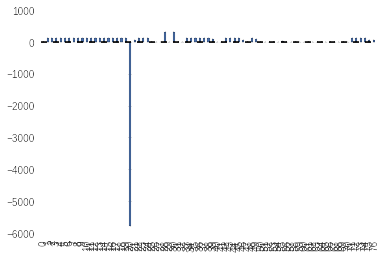

In [65]:
time_between_losses.plot(kind='bar')